In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import utils # local file

#plt.rcParams['figure.dpi'] = 200.0
#plt.rcParams['figure.facecolor'] = 'w'
#plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 15.0
#plt.rcParams['text.usetex'] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = pd.read_csv('./2020_Problem_D_DATA/passingevents.csv')
df

,MatchID,TeamID,OriginPlayerID,DestinationPlayerID,MatchPeriod,EventTime,EventSubType,EventOrigin_x,EventOrigin_y,EventDestination_x,EventDestination_y
0,1,Huskies,Huskies_D1,Huskies_F1,1H,46.323501,Head pass,34,97,59.0,95.0
1,1,Huskies,Huskies_M1,Huskies_F2,1H,51.022546,Simple pass,53,89,69.0,91.0
2,1,Opponent1,Opponent1_D2,Opponent1_G1,1H,89.008721,Simple pass,19,16,5.0,50.0
3,1,Opponent1,Opponent1_G1,Opponent1_F1,1H,92.216160,Launch,5,50,67.0,44.0
4,1,Huskies,Huskies_M2,Huskies_M3,1H,98.265191,Simple pass,42,55,36.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...
23424,38,Opponent14,Opponent14_M3,Opponent14_D1,2H,2758.973892,Simple pass,57,56,65.0,63.0
23425,38,Opponent14,Opponent14_D1,Opponent14_D6,2H,2760.286946,Simple pass,65,63,61.0,96.0
23426,38,Opponent14,Opponent14_D6,Opponent14_M4,2H,2763.698599,Simple pass,61,96,40.0,85.0
23427,38,Opponent14,Opponent14_M4,Opponent14_M2,2H,2783.137836,Simple pass,59,70,53.0,89.0


In [5]:
df = df[df['TeamID'] == 'Huskies'] # We only study Huskies now

In [6]:
# calculate average position of each player
uniq_player = np.unique(
    np.union1d(df['OriginPlayerID'], df['DestinationPlayerID']))
x_mean = [
    np.mean(
        list(df[df['OriginPlayerID'] == name]['EventOrigin_x']) +
        list(df[df['DestinationPlayerID'] == name]['EventDestination_x']))
    for name in uniq_player
]
y_mean = [
    np.mean(
        list(df[df['OriginPlayerID'] == name]['EventOrigin_y']) +
        list(df[df['DestinationPlayerID'] == name]['EventDestination_y']))
    for name in uniq_player
]

pos = {
    name: np.array([x_mean[i], y_mean[i]])
    for i, name in enumerate(uniq_player)
}

In [7]:
# Build Directional graph
G = nx.from_pandas_edgelist(df, source='OriginPlayerID', 
                            target='DestinationPlayerID', 
                            edge_attr=True, 
                            create_using=nx.DiGraph())

In [12]:
# Calculate degree centrality
deg_centrality = nx.algorithms.centrality.degree_centrality(G)
deg_centrality = np.array([deg_centrality[node] for node in list(G.nodes())])

# Calculate betweenness centrality
between_centrality = nx.algorithms.centrality.betweenness_centrality(G)
between_centrality = np.array([between_centrality[node] for node in list(G.nodes())])

# Calculate total (in + out) passes through a node
huskie_passes = utils.Huskies_passing_table('./2020_Problem_D_DATA/passingevents.csv')
node_passes = np.array([np.sum(huskie_passes[node]) for node in list(G.nodes())])

In [13]:
## Calculate passes from A to B
df_huskies = df[['OriginPlayerID', 'DestinationPlayerID']]
# Multi-Directional graph
H = nx.from_pandas_edgelist(df_huskies, source='OriginPlayerID', 
                            target='DestinationPlayerID', edge_attr=True, 
                            create_using=nx.MultiDiGraph())

unidirection_pass = {}
for edge in H.edges:
    unidirection_pass[(edge[0], edge[1])] = H.number_of_edges(edge[0], edge[1])

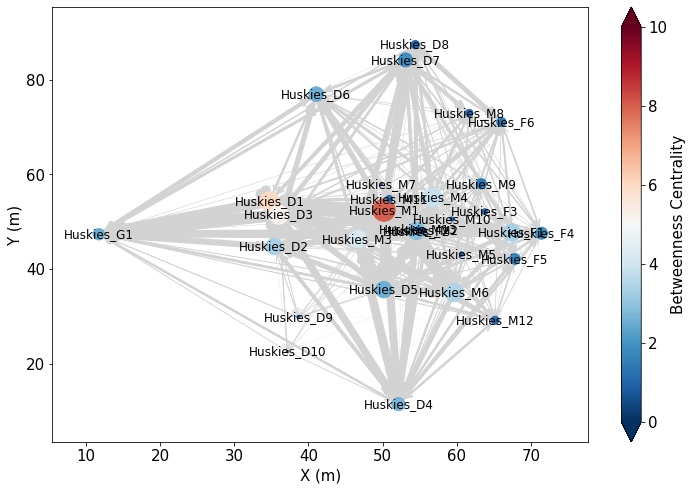

In [25]:
# Plot the network
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw_networkx(G, pos, ax=ax, 
                 node_size=np.exp(3 * deg_centrality), 
                 node_color=np.exp(70 * between_centrality), 
                 edgelist=list(unidirection_pass.keys()), 
                 width=np.array(list(unidirection_pass.values())) / 10,
                 edge_color='lightgray', cmap='RdBu_r', vmin=0, vmax=10, arrowsize=15, arrowstyle='->')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')

sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=0, vmax=10))
cbar = plt.colorbar(sm, ax=ax, extend='both')
cbar.set_label('Betweenness Centrality')
#fig.colorbar(neg, ax=ax)
#, width=edge_passes)

## Calculate Motifs

In [45]:
mcounter(G, motifs)

{'S1': 0, 'S2': 0, 'S3': 0, 'S4': 1, 'S5': 0}

In [44]:
## We define each S* motif as a directed graph in networkx
motifs = {
    'S1': nx.DiGraph([(1,2),(2,3)]),
    'S2': nx.DiGraph([(1,2),(1,3),(2,3)]),
    'S3': nx.DiGraph([(1,2),(2,3),(3,1)]),
    'S4': nx.DiGraph([(1,2),(3,2)]),
    'S5': nx.DiGraph([(1,2),(1,3)])
    }



def mcounter(gr, mo):
    """Counts motifs in a directed graph
    :param gr: A ``DiGraph`` object
    :param mo: A ``dict`` of motifs to count
    :returns: A ``dict`` with the number of each motifs, with the same keys as ``mo``
    This function is actually rather simple. It will extract all 3-grams from
    the original graph, and look for isomorphisms in the motifs contained
    in a dictionary. The returned object is a ``dict`` with the number of
    times each motif was found.::
        >>> print mcounter(gr, mo)
        {'S1': 4, 'S3': 0, 'S2': 1, 'S5': 0, 'S4': 3}
    """
    import itertools
    #This function will take each possible subgraphs of gr of size 3, then
    #compare them to the mo dict using .subgraph() and is_isomorphic
    
    #This line simply creates a dictionary with 0 for all values, and the
    #motif names as keys

    mcount = dict(zip(mo.keys(), list(map(int, np.zeros(len(mo))))))
    nodes = gr.nodes()

    #We use iterools.product to have all combinations of three nodes in the
    #original graph. Then we filter combinations with non-unique nodes, because
    #the motifs do not account for self-consumption.

    triplets = list(itertools.product(*[nodes, nodes, nodes]))
    triplets = [trip for trip in triplets if len(list(set(trip))) == 3]
    triplets = map(list, map(np.sort, triplets))
    u_triplets = []
    [u_triplets.append(trip) for trip in triplets if not u_triplets.count(trip)]

    #The for each each of the triplets, we (i) take its subgraph, and compare
    #it to all fo the possible motifs

    for trip in u_triplets:
        sub_gr = gr.subgraph(trip)
        mot_match = list(map(lambda mot_id: nx.is_isomorphic(sub_gr, mo[mot_id]), motifs.keys()))
        match_keys = [list(mo.keys())[i] for i in range(len(mo)) if mot_match[i]]
        if len(match_keys) == 1:
            mcount[match_keys[0]] += 1

    return mcount